In [3]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import json
import pandas as pd

# Naive CF-Descent

This file contains the initial attempts at making CF-Descent work and tests to see it's validity

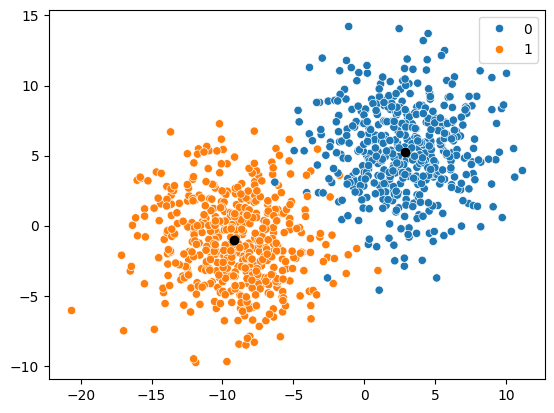

In [38]:
X, y, centers = make_blobs(centers=2, cluster_std=3, n_features=2, n_samples=1000, return_centers=True)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
plt.scatter(x=centers[0][0], y=centers[0][1],color="black")
plt.scatter(x=centers[1][0], y=centers[1][1],color="black")

In [39]:
model = RandomForestClassifier()
model.fit(X, y)
pred = model.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

,x1,x2,label
0,-6.416281,-1.814604,1.0
1,2.038185,3.898228,0.0
2,-2.580389,-2.260205,1.0
3,2.236304,0.980198,0.0
4,-10.277563,-3.484612,1.0
...,...,...,...
995,5.669258,6.594815,0.0
996,-10.756932,1.893334,1.0
997,-5.727165,-3.812083,1.0
998,-10.499139,0.339216,1.0


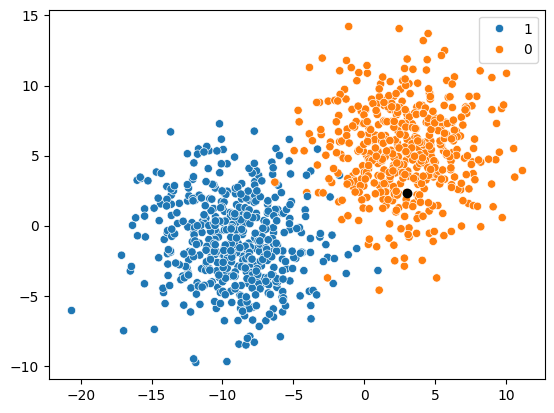

In [246]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=pred)
plt.scatter(x=df.values[5][0],y=df.values[5][1],color='black')

In [241]:
def euclid_dis(x,y):
    return np.linalg.norm(x-y)

euclid_dis(np.array((-3,-1)),np.array((1,1)),)

np.float64(4.47213595499958)

In [256]:
def Naive_CF_Descent(df, model, target, centers, instance_index, stop_count, step_size, limit = 50000, dis = lambda a,b : euclid_dis(a,b)):
    cf = centers[int(target)]
    target_points = df[df["label"] == target]

    history = []
    misses = 0
    instance = df.values[instance_index]
    if instance[2] == target:
        raise Exception("cannot create CF for current class")

    it = 0
    while misses < stop_count and it < limit:
        y = target_points.sample().values[0]

        best = (cf,0)
        
        for i in range(len(y)-1):
            cf_prime = cf.copy()
            cf_prime[i] += y[i] * step_size
            distance_new = dis(cf_prime[:-1], instance[:-1])
            distance_old = dis(best[0][:-1], instance[:-1])

            if distance_new < distance_old:
                best = (cf_prime, i)
        
        if all([x == y for x,y in zip(cf,best[0])]):
            misses += 1
        else:
            try:
                prediction = model.predict([cf_prime])
                if prediction[0] != int(target):
                    print("faulty counterfactual")
                    misses += 1
                    it += 1
                    continue
            except ValueError:
                print("fail")
                misses += 1
                it += 1
                continue

            cf = cf_prime
            misses = 0
            history.append(best)
        it += 1

    print("Amount of changes: ", len(history))
    return instance,cf,history

In [257]:
x,cf,h = Naive_CF_Descent(df,model, 1.0, centers, 5, 2000, 0.1)

Amount of changes:  25


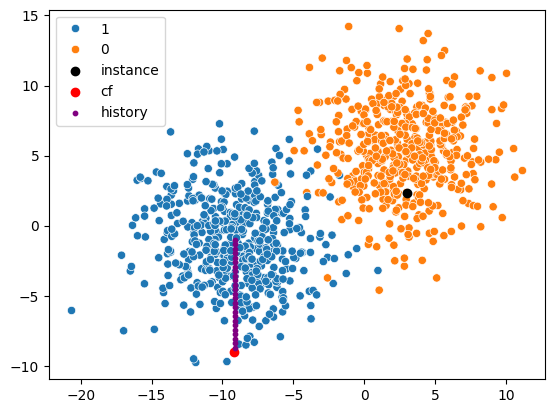

In [290]:
new_h = list(zip(*h))[0]
hx = list(zip(*new_h))[0]
hy = list(zip(*new_h))[1]
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=pred)
plt.scatter(x=x[0],y=x[1],color='black',label='instance')
plt.scatter(x=cf[0],y=cf[1],color='red', label='cf')
plt.scatter(x=hx, y=hy, color='purple', label='history',s=10)
plt.legend()